In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression


In [2]:
NUM_RUNS = 10
NUM_FEATURES = 100
NUM_BINS = 45
NUM_SAMPLES = 10_000 #10_000
# Generate synthetic regression data
X, y = make_regression(n_samples=NUM_SAMPLES, n_features=NUM_FEATURES, noise=0.1, random_state=1)

# Convert to pandas DataFrame
df = pd.DataFrame(data=X, columns=[f'Feature_{i}' for i in range(1, NUM_FEATURES+1)])
df['Target'] = y

df_data = df.drop('Target', axis=1).astype('float32')

print(df_data.head())

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   2.669134   0.935506   0.119068   0.397455  -0.797867   1.063694   
1  -0.280565  -0.737132  -0.073916   0.266521   0.950513  -0.318143   
2  -1.545541  -0.813349   2.552004  -1.885060   1.019922  -0.546040   
3  -0.176935   1.082176   1.856537  -0.444410   0.462096   0.063075   
4   0.730443  -2.839458   0.602569  -0.249875  -1.140106  -0.024486   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_91  Feature_92  \
0   0.223034  -0.394869   0.549681    0.203443  ...   -0.977882   -0.327025   
1   2.210178  -0.486361   1.207417   -0.132859  ...   -1.732534    0.704593   
2  -0.089909  -1.040497   0.124978    0.926639  ...   -0.860770    1.445409   
3   1.173178  -0.860313   0.186985   -0.392830  ...   -0.649400   -1.150807   
4   0.068322   0.137987   1.836735   -0.455747  ...    0.026673    1.308732   

   Feature_93  Feature_94  Feature_95  Feature_96  Feature_97  Feature_98  \
0   -0.995281   -0.82

In [3]:
df_data.dtypes

Feature_1      float32
Feature_2      float32
Feature_3      float32
Feature_4      float32
Feature_5      float32
                ...   
Feature_96     float32
Feature_97     float32
Feature_98     float32
Feature_99     float32
Feature_100    float32
Length: 100, dtype: object

import os
os.environ["NUMBA_DEBUG"] = "1"

In [4]:
%%time
from ple_transformer import PiecewiseLinearEncoderNP, PiecewiseLinearEncoderNumba, PiecewiseLinearEncoderCython

CPU times: user 196 ms, sys: 2.72 ms, total: 199 ms
Wall time: 198 ms


In [5]:
%%time
import time
import pandas as pd
import gc

# helper function to test the different implementations of matrix multiplication
def test_transformer(TransformerToTest, identifier, df, num_bins=45):
    # create the transformer
    transformer_to_test = TransformerToTest(num_bins=num_bins)

    # disable garbage collection to get more accurate timing results
    gc.disable()

    # fit and transform the data
    start_time = time.time()
    transformer_to_test.fit(df)
    end_time = time.time()
    fit_duration = end_time - start_time

    start_time = time.time()
    transformer_to_test.transform(df)
    end_time = time.time()
    transform_duration = end_time - start_time

    # enable garbage collection again
    gc.enable()

    return {"transformer": identifier, "fit_duration": fit_duration, "transform_duration": transform_duration}

test_results = []

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.4 µs


In [6]:
# setup test scenarios
test_scenarios = [
    ("numpy", PiecewiseLinearEncoderNP),
    ("numbav0", PiecewiseLinearEncoderNumba),
    ("numbav1", PiecewiseLinearEncoderNumba),
    ("cython", PiecewiseLinearEncoderCython)
]

In [7]:
%%time
# run test scenarios
for i in range(NUM_RUNS):
    if i % 10 == 0:
        print(f"run {i}")
    for scenario in test_scenarios:
        test_results.append(test_transformer(scenario[1], scenario[0], df_data))

run 0
CPU times: user 14.9 s, sys: 3.16 s, total: 18.1 s
Wall time: 18.1 s


In [8]:
df_results = pd.DataFrame(test_results)

df_results = df_results.groupby('transformer').describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'transformer'}, inplace=True)
df_results.T



0         1         2         3
transformer                 cython   numbav0   numbav1     numpy
fit_duration       count      10.0      10.0      10.0      10.0
                   mean   0.106631  0.109454  0.104349  0.109967
                   std    0.004473  0.017962  0.005151  0.011178
                   min    0.102021  0.098643  0.097433  0.099454
                   25%     0.10375   0.09989  0.100365  0.101229
                   50%    0.106078  0.103436  0.104374  0.105845
                   75%    0.106557  0.109384  0.107082   0.11336
                   90%    0.114024  0.118996  0.108075  0.125827
                   95%    0.114575   0.13862  0.111589  0.129048
                   99%    0.115017   0.15432  0.114399  0.131624
                   max    0.115127  0.158245  0.115102  0.132268
transform_duration count      10.0      10.0      10.0      10.0
                   mean   0.151613  0.518745  0.303054  0.398693
                   std    0.013715  0.698743   0.01657  0.022129
                   min    0.140176  0.284021  0.284259  0.370993
                   25%    0.142562  0.290022  0.289213    0.3794
                   50%    0.145259  0.300563   0.30328  0.399482
                   75%    0.156379  0.306949  0.310589  0.410144
                   90%    0.165528  0.535425  0.319675   0.42624
                   95%    0.174641  1.521299  0.328425   0.43093
                   99%    0.181933  2.309998  0.335426  0.434683
                   max    0.183755  2.507173  0.337176  0.435621

In [9]:
# Define the order of the categories
order = ['numpy', 'numbav0', 'numbav1', 'cython']

# Convert the 'transformer' column to a categorical type
df_results['transformer'] = df_results['transformer'].astype('category')
df_results['transformer'] = df_results['transformer'].cat.set_categories(order)
df_results.sort_values('transformer', inplace=True)

# compute speed up relative to numpy
df_results['speed_up'] = df_results[df_results.transformer == 'numpy'][('transform_duration', 'mean')].values[0] / df_results[('transform_duration', 'mean')] 
df_results


transformer fit_duration                                                    \
                     count      mean       std       min       25%       50%   
3       numpy         10.0  0.109967  0.011178  0.099454  0.101229  0.105845   
1     numbav0         10.0  0.109454  0.017962  0.098643  0.099890  0.103436   
2     numbav1         10.0  0.104349  0.005151  0.097433  0.100365  0.104374   
0      cython         10.0  0.106631  0.004473  0.102021  0.103750  0.106078   

                                 ... transform_duration                      \
        75%       90%       95%  ...                std       min       25%   
3  0.113360  0.125827  0.129048  ...           0.022129  0.370993  0.379400   
1  0.109384  0.118996  0.138620  ...           0.698743  0.284021  0.290022   
2  0.107082  0.108075  0.111589  ...           0.016570  0.284259  0.289213   
0  0.106557  0.114024  0.114575  ...           0.013715  0.140176  0.142562   

                                                               speed_up  
        50%       75%       90%       95%       99%       max            
3  0.399482  0.410144  0.426240  0.430930  0.434683  0.435621  1.000000  
1  0.300563  0.306949  0.535425  1.521299  2.309998  2.507173  0.768572  
2  0.303280  0.310589  0.319675  0.328425  0.335426  0.337176  1.315585  
0  0.145259  0.156379  0.165528  0.174641  0.181933  0.183755  2.629680  

[4 rows x 24 columns]

<Figure size 1000x600 with 0 Axes>

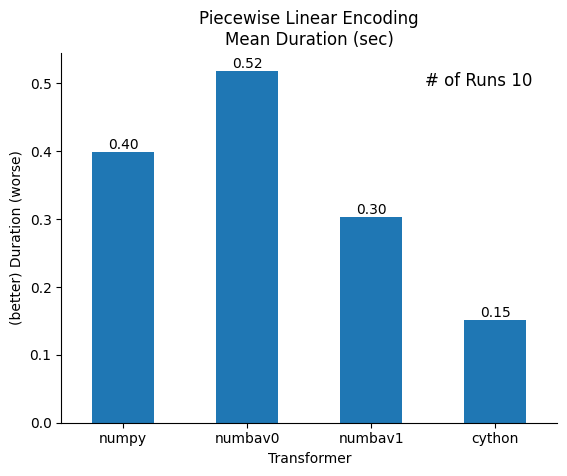

In [10]:
plt.figure(figsize=(10, 6))
bars = df_results.plot(kind='bar', x='transformer', y=('transform_duration', 'mean'), legend=False)

plt.title(f'Piecewise Linear Encoding\nMean Duration (sec)')
plt.xlabel('Transformer')
plt.ylabel('(better) Duration (worse)')

# Remove top and right lines
bars.spines['right'].set_visible(False)
bars.spines['top'].set_visible(False)

# Print x-axis labels horizontally
plt.xticks(rotation='horizontal')

# Annotate each bar with its value
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 5), 
                  textcoords = 'offset points')
    

# Place an annotation in the upper right quadrant of the chart
bars.annotate(
    f"# of Runs {NUM_RUNS}", 
    xy=(0.95, 0.95), 
    xycoords='axes fraction', 
    ha='right', 
    va='top',
    fontsize=12
)

# Save the plot as an image
plt.savefig(f'ple_duration_runs_{NUM_RUNS}.png')

plt.show()

<Figure size 1000x600 with 0 Axes>

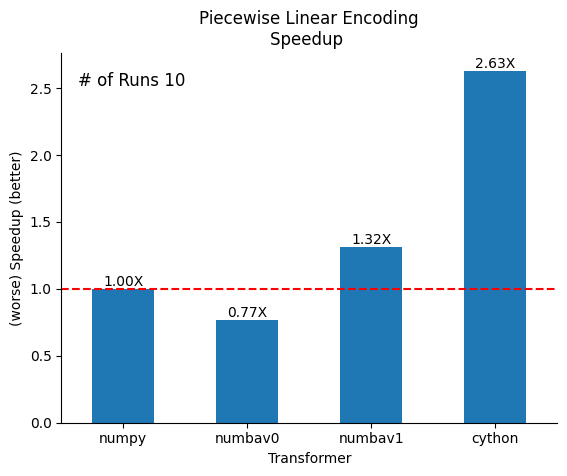

In [11]:
plt.figure(figsize=(10, 6))
bars = df_results.plot(kind='bar', x='transformer', y='speed_up', legend=False)
plt.title(f'Piecewise Linear Encoding\nSpeedup ')
plt.xlabel('Transformer')
plt.ylabel('(worse) Speedup (better)')

# Remove top and right lines
bars.spines['right'].set_visible(False)
bars.spines['top'].set_visible(False)

# Print x-axis labels horizontally
plt.xticks(rotation='horizontal')

# Annotate each bar with its value
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f') + 'X',
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 5), 
                  textcoords = 'offset points')

# Place an annotation in the upper right quadrant of the chart
bars.annotate(
    f"# of Runs {NUM_RUNS}", 
    xy=(0.25, 0.95), 
    xycoords='axes fraction', 
    ha='right', 
    va='top',
    fontsize=12
)

# Get the height of the 'numpy' bar
numpy_height = df_results.loc[df_results['transformer'] == 'numpy', 'speed_up'].values[0]

# Place a horizontal line at the height of the 'numpy' bar
plt.axhline(y=numpy_height, color='r', linestyle='--')


# Save the plot as an image
plt.savefig(f'ple_speedup_runs_{NUM_RUNS}.png')

plt.show()